# Assignment Week 6 and 7 - Location Planning

In [1]:
import numpy as np
import pandas as pd
import random
import gurobipy as gp
from gurobipy import *
import matplotlib.pyplot as plt

In [2]:
# Loading necessary data
path_data = "../Advanced Data Science Data/"
df_incidents = pd.read_csv(path_data + "Incidents_11-05.csv")
df_candidates = pd.read_csv(path_data + "unique_candidates_11-05.csv")
d = np.load(path_data + "cost_matrix.npy")

In [3]:
# Filtering and organising data
df_incidents_fil = df_incidents[["dutch_rd_x", "dutch_rd_y", "type"]]
arr_incidents = df_incidents_fil[["dutch_rd_x", "dutch_rd_y"]].to_numpy()
arr_candidates = df_candidates[["first_point_x", "first_point_y"]].to_numpy()
d = np.reshape(d, (np.shape(arr_candidates)[0], np.shape(arr_incidents)[0]))

In [4]:
print(d.shape)
print(arr_incidents.shape)
print(arr_candidates.shape)

if d.shape[0] != arr_candidates.shape[0] or d.shape[1] != arr_incidents.shape[0]:
    raise ValueError("Dimensions do not match")

(1416, 678)
(678, 2)
(1416, 2)


In [5]:
display(np.where(d[0,:]!=10000000))

(array([ 14,  15,  19,  25,  26,  40,  46,  51,  53,  58,  71,  73, 111,
        121, 162, 177, 193, 216, 221, 224, 241, 253, 256, 257, 258, 260,
        263, 267, 269, 270, 290, 293, 309, 315, 320, 328, 344, 382, 387,
        390, 431, 450, 457, 497, 503, 505, 507, 538, 540, 544, 546, 552,
        554, 581, 583, 617, 618, 621, 633, 638, 639, 664, 667, 669, 670,
        672, 675], dtype=int64),)

In [6]:
print(d[0,np.where(d[0,:]<1e7)])

[[ 91924.  16420.  16420.  76080.  47864.  53412.  31795.  32072.  36487.
   24984.  16372.  16372. 104001. 104001. 108181. 108181. 179187. 179187.
   87539. 122005.  88453.  37700.  57600.  58155.  58155. 179187.  53590.
   54704. 110883.  57600.  41900.  41900.   2386. 118479.  53590. 118479.
   43884.  69034.  86079.  35663.  49956.  99804.  35663.  97454.  67062.
   67062.  33937.  67062.  19748.  19748.  15785.  92219. 201582.  35328.
   69034.  77436. 119989.  77436.  81378.  62270.  10759.]]


# Model

In [7]:
model = Model("Road inspectors")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


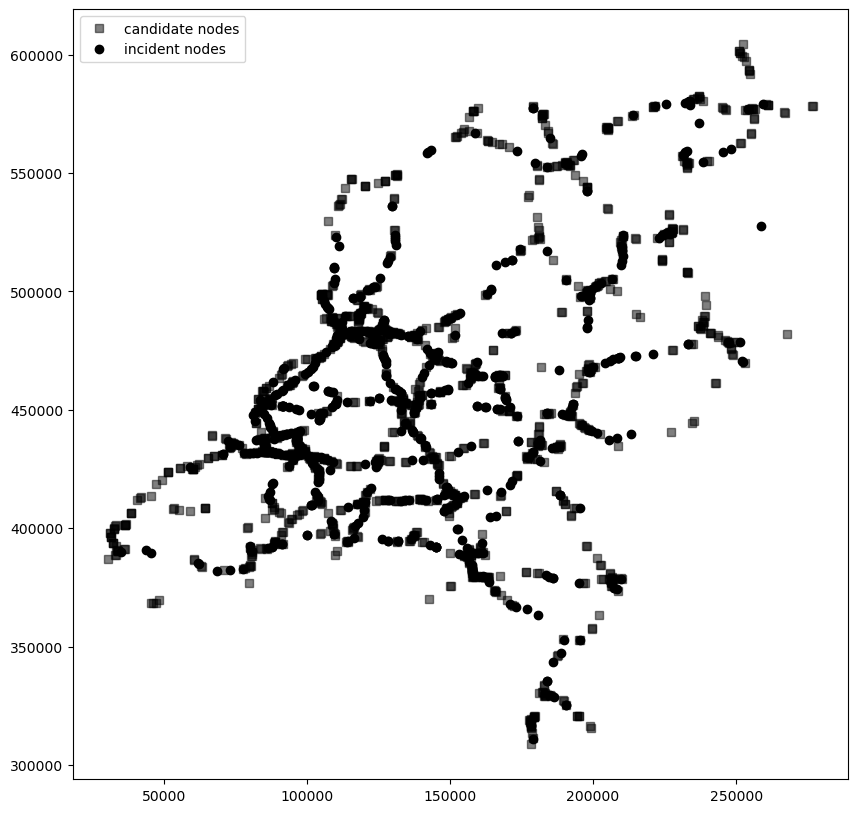

In [8]:
# np.random.seed(20)
# candidates = np.random.randint(0, 1000, (50, 2))
# incidents = np.random.randint(0, 1000, (25, 2))
candidates = arr_candidates
incidents = arr_incidents

plt.figure(figsize=(10, 10))
plt.plot(candidates[:, 0], candidates[:, 1], 'ks', alpha=0.5, label='candidate nodes')
plt.plot(incidents[:, 0], incidents[:, 1], 'ko', label='incident nodes')
plt.legend()

In [22]:
N = np.arange(candidates.shape[0])
K = np.arange(incidents.shape[0])
# M = 99999 # Big M
# Parameters
# d = np.ones(((N.shape[0], K.shape[0])), dtype=float) * M
# for i in range(N.shape[0]):
#     for k in range(K.shape[0]):
#         d[i, k] = np.sqrt(np.sum((candidates[i, :] - incidents[k, :]) ** 2))

inspector_cap = 20
N_inspectors = 800

In [23]:
pair = [(i, k) for i in N for k in K]
x = model.addVars(pair, vtype=GRB.BINARY, name="x")
c = model.addVars(N, vtype=GRB.BINARY, name="c")

model.Params.IntegralityFocus=0 
model.update()

In [24]:
model.setObjective(quicksum(d[i, k] * x[i, k] for i in N for k in K),
                   GRB.MINIMIZE)

In [25]:
model.addConstrs(quicksum(x[i, k] for i in N) == 1 for k in K);

In [26]:
model.addConstrs(quicksum(x[i, k] for k in K) <= inspector_cap * c[i] for i in N);

In [27]:
model.addConstr(quicksum(c[i] for i in N) <= N_inspectors);

In [28]:
model.update()

In [29]:
model.optimize()

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4190 rows, 1922928 columns and 3845856 nonzeros
Model fingerprint: 0x7c1ce8ea
Variable types: 0 continuous, 1922928 integer (1922928 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+01, 1e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+02]

MIP start from previous solve produced solution with objective 5.73018e+08 (3.66s)
Loaded MIP start from previous solve with objective 5.73018e+08
Processed MIP start in 3.73 seconds (4.28 work units)

Presolve removed 2095 rows and 961464 columns
Presolve time: 4.88s
Presolved: 2095 rows, 961464 columns, 1922928 nonzeros
Variable types: 0 continuous, 961464 integer (961464 binary)
Deterministic concurrent LP optimizer: primal simplex, dua

In [30]:
# Print selected facilities
inspectors = []

for i in N:
    for k in K:
        if x[i, k].x == 1:
            inspectors.append(i)
inspectors = np.unique(inspectors)
print('Selected inspectors are nodes '+ str(inspectors))

Selected inspectors are nodes [   0    1    6    7   10   12   20   28   42   47   59   61   63   65
   68   69   74   76   85   88   89   98  101  103  107  113  114  120
  121  137  140  143  144  145  153  156  160  165  172  174  177  178
  179  181  186  188  200  201  203  204  206  207  208  210  223  233
  236  237  240  244  247  253  257  261  284  289  292  297  306  307
  308  328  329  342  344  347  351  356  361  368  369  370  373  375
  377  378  392  396  397  411  416  417  419  420  421  426  427  436
  451  454  461  470  472  474  476  478  480  483  496  497  499  500
  503  507  516  519  524  526  529  532  538  542  548  551  552  556
  557  563  568  570  575  578  587  589  604  605  606  609  615  619
  620  625  632  636  640  641  643  646  650  653  657  668  682  685
  693  694  704  705  707  713  714  716  717  719  731  732  733  738
  747  755  757  771  776  777  778  780  785  786  796  797  798  799
  803  804  806  811  812  825  826  832  833  

In [31]:
print(f'Minimum total cost is {model.ObjVal/1000:.2f} km')
print(f'Number of inspectors is {len(inspectors)}')
print(f'Average distance per inspector {model.ObjVal / len(inspectors)/1000 :.2f} km')
print(f'Average time to reach the incident is {model.ObjVal / len(inspectors) / 100 / 1000 * 60 :.2f} minutes')

Minimum total cost is 573017.65 km
Number of inspectors is 313
Average distance per inspector 1830.73 km
Average time to reach the incident is 1098.44 minutes


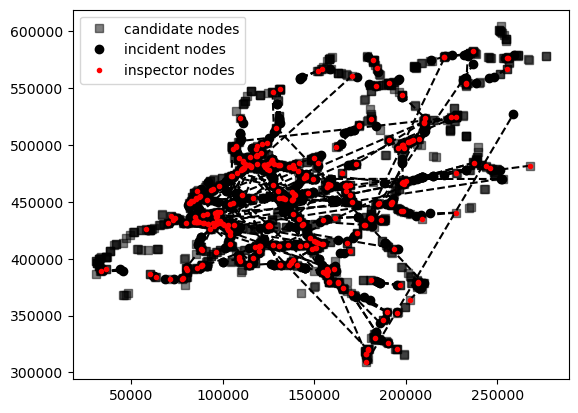

In [32]:
inspector_coordinate = np.zeros((len(inspectors), 2))

for i in range(len(inspectors)):
    inspector_coordinate[i, :] = candidates[inspectors[i], :]
    
for i in N:
    for k in K:
        if x[i, k].x == 1:
            plt.plot((candidates[i, 0], incidents[k, 0]),
                    (candidates[i, 1], incidents[k, 1]),
                    c='black', linestyle='--')

plt.plot(candidates[:, 0], candidates[:, 1], 'ks', alpha=0.5, label='candidate nodes')
plt.plot(incidents[:, 0], incidents[:, 1], 'ko', label='incident nodes')
plt.plot(inspector_coordinate[:, 0], inspector_coordinate[:, 1], 'r.', label='inspector nodes')
plt.legend()